## **Pulsar timing array 12.5 year gravitational wave background tutorial**

In this tutorial, we will walk through the analysis of a single pulsar from the 12.5 year dataset analysis for the gravitational wave background which is treated as a common red noise among the pulsars. First, we will use `J1909` which according to the dropout analysis supports such a signal, and then `J1713` which does not support the gravitational wave background. To use the entire pulsar timing array, a significant amount of computation will be required. Because of this, it is recommended that you download the relevant parts and run them on your own computer (or computational cluster).

We start here by installing the necessary software to our google colab notebook. For installation instructions to run this notebook on your own computer, see (insert github link here)

# Run once

In [1]:
!pip install pyephem
!pip install git+https://github.com/dfm/acor.git
!pip install astropy
!pip install jplephem
!pip install Cython
!pip install corner
!apt install libtool
!apt install autoconf
!apt install libsuitesparse-dev
!pip install scikit-sparse
!pip install git+https://github.com/vallis/libstempo.git
!pip install git+https://github.com/nanograv/PINT.git
!pip install git+https://github.com/nanograv/enterprise.git
!pip install git+https://github.com/nanograv/enterprise_extensions
!pip install git+https://github.com/jellis18/PTMCMCSampler
!pip install mpi4py
!pip install git+https://github.com/nanograv/enterprise_extensions.git
!pip install healpy

     |████████████████████████████████| 1.2MB 2.7MB/s 
  Created wheel for pyephem: filename=pyephem-3.7.7.0-cp36-none-any.whl size=1463 sha256=25823bc6976e85a8549f7e4de171e708a966b27c1391dcbab892699be5907e25
  Stored in directory: /root/.cache/pip/wheels/41/6c/61/6f7156f2473f0561c3c8eee8e6f091274d9b7d46555d6d0890
Successfully built pyephem
  Found existing installation: ephem 3.7.7.1
    Uninstalling ephem-3.7.7.1:
      Successfully uninstalled ephem-3.7.7.1
  Cloning https://github.com/dfm/acor.git to /tmp/pip-req-build-l80tzdbt
  Running command git clone -q https://github.com/dfm/acor.git /tmp/pip-req-build-l80tzdbt
  Created wheel for acor: filename=acor-1.1.1-cp36-cp36m-linux_x86_64.whl size=25632 sha256=42f49178a5880b3f5f1437ee527f2c63cee3c6098cd6b898e07a649b424387b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-myfqzqcz/wheels/ea/16/75/7b822064fa34905cc7903088b695b8aca106158a333c9f328d
Successfully built acor
     |████████████████████████████████| 40kB 1.5MB/s 
  Created 

This repository contains the data needed to analyze these two pulsars.

In [2]:
!rm -r nanograv_12yr_tutorial/
!git clone https://github.com/AaronDJohnson/nanograv_12yr_tutorial.git

rm: cannot remove 'nanograv_12yr_tutorial/': No such file or directory
Cloning into 'nanograv_12yr_tutorial'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 126 (delta 54), reused 112 (delta 43), pack-reused 0
Receiving objects: 100% (126/126), 23.85 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (104/104), done.


# Start here if everything is already installed (otherwise see "Run once" section)


Next, we import the python files that are needed for our analysis. Many of these files are from `enterprise`, a suite of tools to aid in the analysis of pulsar timing data.

In [3]:
import numpy as np
import glob, os, json

import matplotlib.pyplot as plt
import corner
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

Load the par and tim files for a single pulsar, J1713+0747. This is one of the best pulsars in the NANOGrav array. The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.

In [4]:
datadir = 'nanograv_12yr_tutorial/data/'

psrstring = 'J1909'  # two exist in this dataset: 1909 and 1713

parfiles = sorted(glob.glob(datadir + psrstring + '*.par'))
timfiles = sorted(glob.glob(datadir + psrstring + '*.tim'))

ephemeris = 'DE438'

psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)


In [5]:
import pickle

pickle.dump(psrs, open( "J1909.pkl", "wb" ))

In [2]:
psrs = pickle.load(open('J1909.pkl', "rb"))

In [11]:
# load the white noise parameters from the noisefiles
noisefiles = glob.glob( '*.json')

params = {}
for nf in noisefiles:
    with open(nf, 'r') as f:
        params.update(json.load(f))

# Single Pulsar Analysis

In [12]:
print(psrs)
psr = psrs[0]

In [13]:
print(psr.name)

J1909-3744


In [14]:
# find the maximum time span to set red-noise/DM-variation frequency sampling
tmin = psr.toas.min()
tmax = psr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)
print('Tspan =', Tspan / 3600 / 24 / 365, 'years')  # time in years
print('Number of TOAs =', len(psr.toas))

Tspan = 12.702235010508442 years
Number of TOAs = 22633


Plot the residuals:

Number of TOAs: 22633


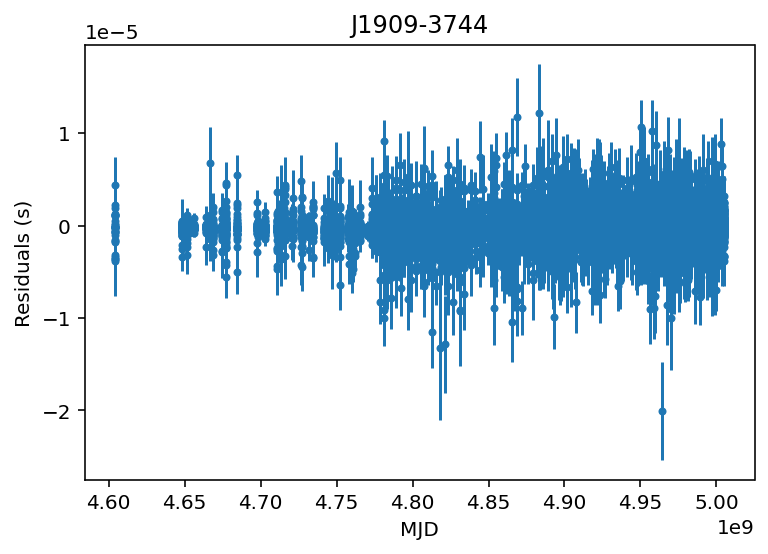

In [15]:
delta_t = psr.toas

print('Number of TOAs: {0}'.format(len(psr.toas)))

plt.errorbar(delta_t, psr.residuals, ls='', marker='.', yerr=psr.toaerrs)

plt.ylabel('Residuals (s)');
plt.xlabel('MJD');

plt.title(psr.name);

These TOAs are made up of several components: white noise, red noise, and possibly even a common red noise that is the gravitational wave background.

First, let's add the white noise. There are three terms describing white noise: EFAC, which is a linear scaling of the TOA uncertainties; EQUAD, which is white noise added in quadrature to the TOA uncertainties; and ECORR, which is correlated over a single observation but uncorrelated between different observations.

In our analysis, we will fix the white noise to the maximum-likelihood values, which are found from noise analyses run on each pulsar. For now, we will initialize the white noise parameters as constants.

In a PTA-wide analysis we would vary the white noise for individual pulsars and set the parameters to their most likely values when using all the pulsars. This reduces the number of parameters in our model and save a significant amount of time. On a single pulsar, this will make the computation take minutes instead of days.


In [ ]:
# white noise parameters: varying the white noise will add more parameters to our model
white_vary = False
if white_vary:
    efac = parameter.Uniform(0.01, 10.0)
    equad = parameter.Uniform(-8.5, -5)
    ecorr = parameter.Uniform(-8.5, -5)
else:
    efac = parameter.Constant() 
    equad = parameter.Constant() 
    ecorr = parameter.Constant() # we'll set these later with the params dictionary

# there will be separate white noise parameters for each observing backend
# since NANOGrav began taking data, there have been two generations of backends
# (ASP and PUPPI at Arecibo, GASP and GUPPI at Green Bank)
selection = selections.Selection(selections.by_backend)

# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

Now we add in the red noise. We model the red noise as a power law with two parameters: an amplitude and spectral index.

In [ ]:
# red noise parameters
log10_A = parameter.LinearExp(-18, -11)
gamma = parameter.Uniform(0, 7)

# define powerlaw PSD and red noise signal
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(pl, components=30, name='rn')

We also include contributions from the pulsar's timing model.

In [ ]:
# linearized timing model
tm = gp_signals.TimingModel(use_svd=True)  # stabilize the timing model with SVD

Finally, we define the GW background. We model the background as a power law with fixed spectral index and an amplitude parameter. You can also do runs where you vary the spectral index and the amplitude simultaneously.

In [ ]:
# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_Agw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_Agw, gamma=gamma_gw)
gwb = gp_signals.FourierBasisGP(spectrum=cpl, components=30, name='gwb')

Now we put together all of the signals to define the model.

In [ ]:
# full model
s = ef + eq + ec + rn + tm + gwb

Since we are only analyzing a single pulsar, we will not include ephemeris modeling into the model.

In [ ]:
# if you want to include ephemeris modeling, set bayesephem = True
bayesephem = False
if bayesephem:
    s += deterministic_signals.PhysicalEphemerisSignal(use_epoch_toas=True)

Now we initalize the model and the PTA object.

In [ ]:
# initialize PTA
model = [s(psr) for psr in psrs]
pta = signal_base.PTA(model)

We get the pulsars' white noise parameters from their noise files.

In [ ]:
# load the white noise parameters from the noisefiles
noisefiles = glob.glob(datadir + '*.json')

setpars = {}
for nf in noisefiles:
    with open(nf, 'r') as fin:
        setpars.update(json.load(fin))

# fix the white noise parameters to the values in the noisefiles
pta.set_default_params(setpars)

INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GASP_efac to 0.9505606759311833
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GUPPI_efac to 1.0339776268866265
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GASP_efac to 1.0504080629362422
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GUPPI_efac to 1.0313779800296294
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GASP_log10_equad to -7.456278210493956
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GUPPI_log10_equad to -8.171553179171445
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GASP_log10_equad to -7.037406290351743
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr_800_GUPPI_log10_equad to -7.365322642903795
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GASP_log10_ecorr to -8.078816887958723
INFO: enterprise.signals.signal_base: Setting J1909-3744_Rcvr1_2_GUPPI_log10_ecorr t

Here we draw the initial values for the parameters.

This model only contains three parameters since we are only analyzing one pulsar, and we are not including `BayesEphem`. In general, if you run a gravitational wave search with fixed spectral index and without `BayesEphem`, you will have 2N + 1 parameters, where N is the number of pulsars in the PTA.



In [ ]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

pta.params

[J1713+0747_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1713+0747_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 gw_log10_A:Uniform(pmin=-18, pmax=-14)]

Setup the sampler

In [ ]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)  # helps to tune MCMC proposal distribution

# where chains will be written to
outdir = datadir + '/chains_singlepsr_test_{}/'.format(str(psr.name))

# sampler object: this sets the likelihood function and prior
sample = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outdir, resume=False)

Sample the posterior! This may take a while.

In [ ]:
# sampler for N steps
N = int(1e6)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution

# You can keep all these set at default values
# by default, the sampler saves every 10th step in the chain file
sample.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/usr/local/lib/python3.6/dist-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent in 24.831321 s Acceptance rate = 0.295Adding DE jump with weight 50
Finished 99.90 percent in 2546.767093 s Acceptance rate = 0.372633
Run Complete


# Post processing

Now that the MCMC has completed, let's look at the chains.

In [ ]:
chain = np.loadtxt(outdir + 'chain_1.txt')
burn = int(0.25 * chain.shape[0])  # experiment with burn-in

In [ ]:
# Find column of chain file corresponding to a parameter
param = 'log10_A_gw'
ind = list(pta.param_names).index(param)

In [ ]:
# print names of parameters we can plot
[print(name) for name in pta.param_names];

J1909-3744_rn_gamma
J1909-3744_rn_log10_A
log10_A_gw


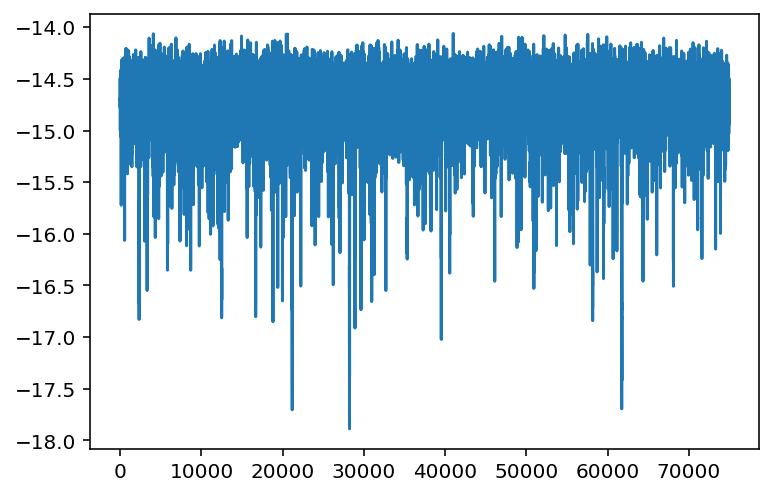

In [ ]:
# Make trace-plot to diagnose sampling
# This should look like a fuzzy caterpillar (and not like a worm)!
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

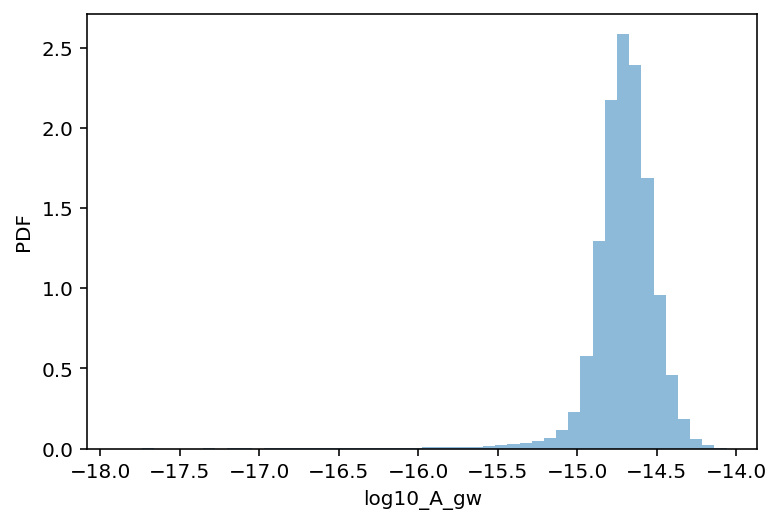

In [ ]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, density=True, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5);
plt.xlabel(str(param))
plt.ylabel('PDF')

The plot clearly indicates that a signal is supported by `J1909`. Gravitational wave background amplitude (logarithmic) can be somewhere between about $-15.5$ and $-14.0$. Let's now turn to `J1713`. To analyze this pulsar, we will use `enterprise_extensions` which has convenient scripts to do exactly everything above in only a few lines.

# `J1713`

In [ ]:
from enterprise_extensions import models, model_utils, sampler

In [ ]:
datadir = 'nanograv_12yr_tutorial/data/'

psrstring = 'J1713'  # two exist in this dataset: 1909 and 1713

parfiles = sorted(glob.glob(datadir + psrstring + '*.par'))
timfiles = sorted(glob.glob(datadir + psrstring + '*.tim'))

ephemeris = 'DE438'

psrs = []
for p, t in zip(parfiles, timfiles):
    psrname = parfiles[0].split('/')[-1].split('_')[0]
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

In [ ]:
pta = models.model_general(psrs, red_psd='powerlaw', common_psd='powerlaw', 
                            red_components=30, common_components=30, 
                            white_vary=False, noisedict=params, tm_svd=True, 
                            gamma_common=4.33, upper_limit_red=False, 
                            upper_limit_common=False, bayesephem=False)

INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_efac to 1.0524302344416032
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_efac to 0.9796026604137508
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GASP_efac to 1.084307149708116
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr1_2_GUPPI_efac to 1.017213088587959
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GASP_efac to 1.117529091199639
INFO: enterprise.signals.signal_base: Setting J1713+0747_Rcvr_800_GUPPI_efac to 1.0500383710337968
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_ASP_efac to 1.1139598766607257
INFO: enterprise.signals.signal_base: Setting J1713+0747_S-wide_PUPPI_efac to 1.0889710082237398
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_ASP_log10_equad to -7.58206720746206
INFO: enterprise.signals.signal_base: Setting J1713+0747_L-wide_PUPPI_log10_equad to -8.377098873197399
INFO: enterprise.signa

In [ ]:
print(len(pta.params))
print(pta.params)

3
[J1713+0747_red_noise_gamma:Uniform(pmin=0, pmax=7), J1713+0747_red_noise_log10_A:Uniform(pmin=-20, pmax=-11), gw_log10_A:Uniform(pmin=-18, pmax=-14)]


In [ ]:
# Setup a sampler instance.
# This will add some fanicer stuff than before, like prior draws, 
# and custom sample groupings.

# where chains will be written to
outdir = datadir + '/chains_singlepsr_test_{}/'.format(str(psr.name))

sample = sampler.setup_sampler(pta, outdir=outdir, resume=False)

Adding red noise prior draws...

Adding GWB uniform distribution draws...



In [ ]:
# sampler for N steps
N = int(1e6)
x0 = x0 = np.hstack(p.sample() for p in pta.params)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
sample.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/enterprise/signals/utils.py:796: RuntimeWarning: invalid value encountered in true_divide
  nmat = Mmat / norm
/usr/local/lib/python3.6/dist-packages/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 1.00 percent in 51.274405 s Acceptance rate = 0.3992Adding DE jump with weight 50
Finished 99.90 percent in 5172.498505 s Acceptance rate = 0.492392
Run Complete


In [ ]:
chain = np.loadtxt(outdir + 'chain_1.txt')
burn = int(0.25 * chain.shape[0])  # experiment with burn-in

In [ ]:
# Find column of chain file corresponding to a parameter
param = 'gw_log10_A'
ind = list(pta.param_names).index(param)

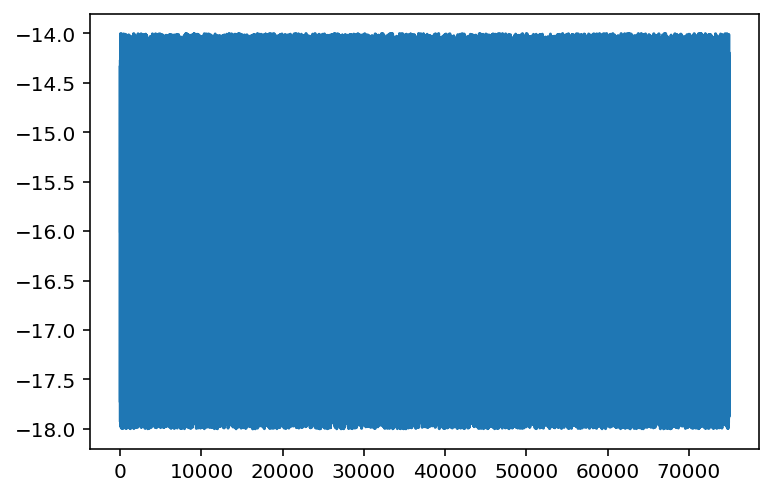

In [ ]:
# Make trace-plot to diagnose sampling
# This should look like a fuzzy caterpillar (and not like a worm)!
plt.plot(chain[burn:, ind])

Text(0, 0.5, 'PDF')

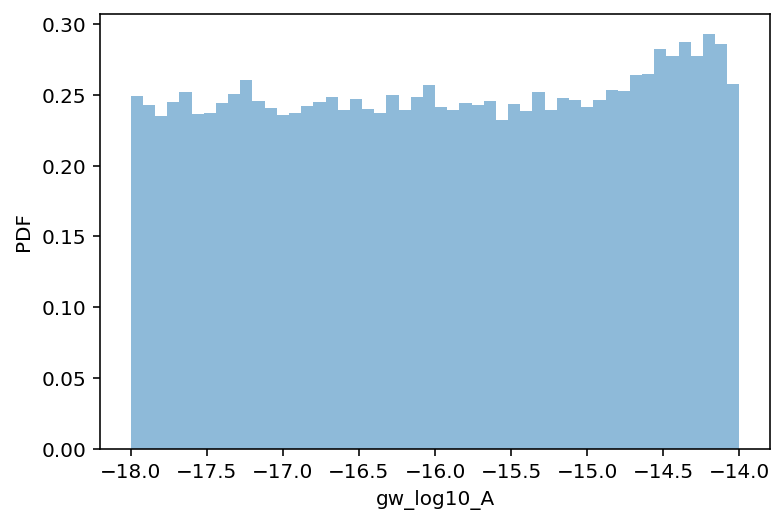

In [ ]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, density=True, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5);
plt.xlabel(str(param))
plt.ylabel('PDF')

While we do see a slight preference for the side where we found the signal in the last pulsar, `J1713` does not support a GWB signal in this data. The distribution ranges over the entire span of parameters.